# Gomory-Hu tree clustering

We try out the Gomory-Hu tree clustering algorithm of Flake, Tarjan and Tsioutsiouliklis. 

First, we do some imports and set up a toy graph.

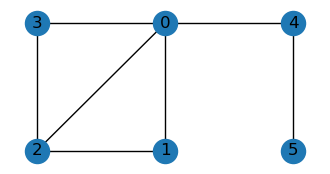

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

def sample_graph():
    G=nx.Graph()
    G.add_edge(0,'1') # why the 1 as a string? Because then it makes a difference whether it's the node number or the node name
    G.add_edge('1',2)
    G.add_edge(3,2)
    G.add_edge(3,0)
    G.add_edge(0,2)
    G.add_edge(0,4)
    G.add_edge(5,4)
    # position dictionary for drawing
    pos={0:(1,1),'1':(1,0),2:(0,0),3:(0,1),4:(2,1),5:(2,0)}
    G.pos=pos
    return G

G=sample_graph()
# give every edge a weight of 1
nx.set_edge_attributes(G, 1, "weight")

fig,ax=plt.subplots(figsize=(4,2))
nx.draw(G,pos=G.pos,ax=ax,with_labels=True)

## Clustering the toy graph

As <code>networkx</code> already knows how to compute a Gomory-Hu tree, it is very easy to implement the Gomory-Hu tree clustering algorithm. Let's first just output the tree -- later on, we'll recover the clusters. One implementation detail: we need to tell <code>nx.gomory_hu_tree</code> how the edge attribute is called that should be taken as the relevant edge weight. This is done by setting the parameter <code>capacity</code>. 

In [2]:
def get_augmented_GH(G,alpha,capacity='weight'):
    to_add=[('t',v,alpha) for v in G.nodes]
    G.add_weighted_edges_from(to_add,weight=capacity)
    T = nx.gomory_hu_tree(G,capacity=capacity)
    return T

To see how the parameter <code>alpha</code> changes the tree, let's apply <code>get_augmented_GH</code> to the toy graph from above with different <code>alpha</code>. Here's a method that plots the trees in a nice way. The code is not very interesting, but you might want to consult the networkx [documentation](https://networkx.org/documentation/stable/reference/drawing.html) to see what options there are when plotting graphs. 

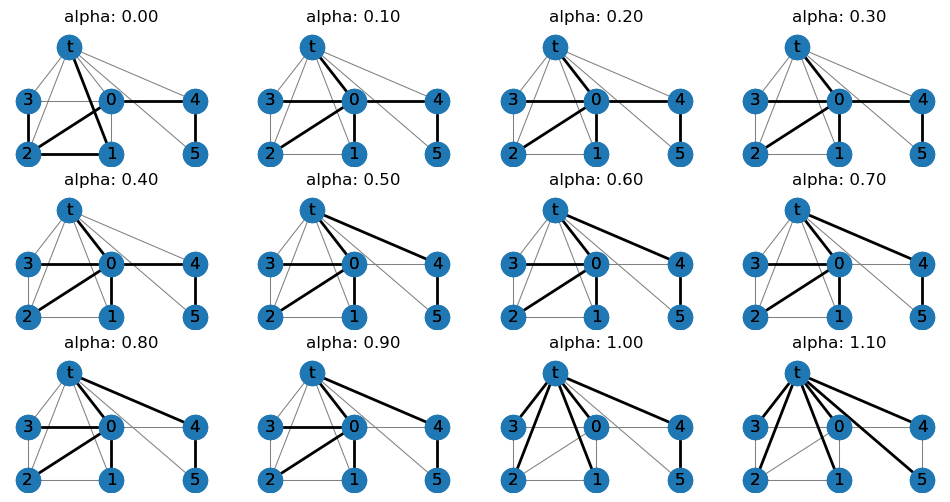

In [3]:
def show_trees(G,alphas,cols=4):
    trees=[get_augmented_GH(G,alpha) for alpha in alphas]
    rows=math.ceil(len(trees)/cols)
    G.pos['t']=(0.5,2)
    fig,axs=plt.subplots(rows,cols,figsize=(3*cols,2*rows))
    axs=axs.flat
    for alpha,tree,ax in zip(alphas,trees,axs):
        nx.draw(G,pos=G.pos,ax=ax,with_labels=True,width=0.75,edge_color='grey')    
        nx.draw(tree,pos=G.pos,ax=ax,with_labels=True,width=2)    
        ax.set_title("alpha: {:.2f}".format(alpha))
    for ax in axs[len(alphas):]:
        ax.remove()

alphas=np.linspace(0.0,1.1,12)
show_trees(G,alphas)

## Clustering a protein-protein interaction graph

Next, let's apply the algorithm to a protein-protein interaction graph that's hosted [here](https://www.inetbio.org/wormnet/downloadnetwork.php). More specifically, we download the protein-protein interaction graph of a common fly. That's *DM-HT* in the list.

We also output the first few lines to get an impression on how the data looks like.

In [4]:
# comment out if you've downloaded the data by hand
!wget -q --show-progress https://www.inetbio.org/wormnet/download.php?type=3&name=DM-HT.txt

counter=0
with open("DM-HT.txt",'r') as f:
    for line in f:
        print(line[:-1])
        counter=counter+1
        if counter==10:
            break

4R79.2	F33A8.4	2.0535098696773
4R79.2	K08E4.1	1.71816616036671
4R79.2	Y37E3.9	2.0535098696773
4R79.2	Y59A8B.1	2.03824718864659
AC3.2	C55A6.10	1.45314520221391
AC3.7	C36B7.6	1.72056305302742
AC3.7	F55F8.5	3.64469409198139
AC3.7	R166.2	3.6241172604793
AC3.8	C36B7.6	2.95263550099055
AC3.8	F55F8.5	3.64590831935301


Okay, so in each line we have data $u$ $v$ $\omega$, where $uv$ is an edge of (interaction) weight $\omega$.

In [5]:
G=nx.read_weighted_edgelist("DM-HT.txt",delimiter='\t',comments='#',create_using=nx.Graph)
G.number_of_nodes(),G.number_of_edges(),nx.density(G)

(2989, 4660, 0.0010435407292155128)

Let's check that all went well.

In [6]:
for u, v, weight in G.edges.data("weight"):
    break
u,v,weight

('4R79.2', 'F33A8.4', 2.0535098696773)

Before we compute a clustering of the graph, let me show off a bit of python magic. Computing the clusters is potentially time consuming, so it'd be nice to track the time spent. With a *decorator* you can write a method to time the execution that works for *any* function. In particular, you can reuse the functionality. If you're interested, [here's](https://realpython.com/primer-on-python-decorators/) more on decorators. 

In [7]:
import time

def timeit(func):
    def wrapper(*args,**kwargs):
        start=time.time()
        print("starting execution...",end='')
        result=func(*args,**kwargs)
        print("done: {:.1f}s".format(time.time()-start))
        return result
    return wrapper

@timeit # this function is *decorated* with timeit
def count(N):
    c=0
    for i in range(N):
        c=c+1

count(10000000)

starting execution...done: 0.6s


Okay, after this short digression let's return to Gomory-Hu tree clustering. We already have almost everything in place -- we only need to compute the components of $T-t$. Fortunately, there's a function for that. 

In [8]:
@timeit  # this function is *decorated* with timeit
def get_clusters(G,alpha,capacity='weight'):
    T=get_augmented_GH(G,alpha,capacity=capacity)
    T.remove_node('t')
    return list(nx.connected_components(T)) # why 'list' here? Because connected_components returns a *generator*.

clusters=get_clusters(G,0.005)
print("found {} clusters".format(len(clusters)))

starting execution...done: 113.6s
found 62 clusters


That took a while...

Over 50 clusters still seems a lot. Are these useful clusters? At a minimum the sizes of the clusters should better mostly be in the mid-range. What would certainly not be a useful clustering: One big cluster and many tiny ones. Let's see.

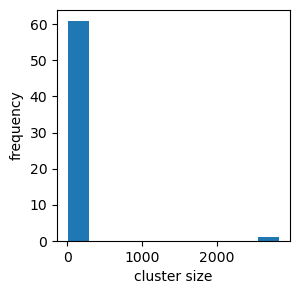

In [9]:
cluster_sizes=[len(cluster) for cluster in clusters]
fig,ax=plt.subplots(figsize=(3,3))
ax.hist(cluster_sizes)
ax.set_xlabel('cluster size')
ax.set_ylabel('frequency')
pass

Ah. So one big cluster and lots of tiny ones. Not very helpful.